In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data_init = pd.read_csv('data/train.csv', encoding='big5')

In [2]:
# 处理降水量列 RAINFALL
days = int(len(data_init) / 18)

RAINFALL_set = set()
for i in range(days):
    day_set = data_init[i*18: (i+1)*18]
    set_t = set(day_set.iloc[10, 3:])
    RAINFALL_set = RAINFALL_set.union(set_t)
print(RAINFALL_set)

{'5', '0', '6.4', '56', '7', '19', '17', '1.4', '27', '6.8', '0.8', '1.2', '12', '4', '3.4', '3.8', '8.4', '8.2', '2.6', '2', '15', '1', '4.2', '9.8', '66', '21', '18', '7.6', '9.2', '0.4', '38', '3', '4.6', '0.2', '4.8', '7.2', '5.4', '3.6', '13', '10', '23', '14', '7.4', '11', '2.4', '1.8', 'NR', '2.8', '74', '8.6', '2.2', '3.2', '0.6', '7.8', '20', '1.6'}


In [3]:
# 将 NR 替换为 0
data = data_init.replace('NR', 0).iloc[:, 3:]
raw_data = data.to_numpy()
raw_data

array([['14', '14', '14', ..., '15', '15', '15'],
       ['1.8', '1.8', '1.8', ..., '1.8', '1.8', '1.8'],
       ['0.51', '0.41', '0.39', ..., '0.35', '0.36', '0.32'],
       ...,
       ['36', '55', '72', ..., '118', '100', '105'],
       ['1.9', '2.4', '1.9', ..., '1.5', '2', '2'],
       ['0.7', '0.8', '1.8', ..., '1.6', '1.8', '2']], dtype=object)

In [4]:
data_init[:18].iloc[:,2]

0       AMB_TEMP
1            CH4
2             CO
3           NMHC
4             NO
5            NO2
6            NOx
7             O3
8           PM10
9          PM2.5
10      RAINFALL
11            RH
12           SO2
13           THC
14         WD_HR
15    WIND_DIREC
16    WIND_SPEED
17         WS_HR
Name: 測項, dtype: object

In [5]:
# 将数据按照月度来分隔， 分成 12个18*(20*24)个数据
month_data = []
for month in range(12):
    sample = np.empty([18, 480])
    for day in range(20):
        # 一天的数据
        begin_row = 18 * (month*20 + day)
        end_row = begin_row + 18
        sample[:, day * 24 : (day+1) * 24] = raw_data[begin_row : end_row, :]
    month_data.append(sample)

# 将数据按照每10小时分隔，前9小时为x，后1小时为y，每个月有471条记录，每个记录有18*9个属性
x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)

# 随机打乱月份
from random import shuffle
idx = [i for i in range(12)]
shuffle(idx)

for i in range(12):
    month = idx[i]
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            row = month*471 + day*24 + hour
            begin_column = day*24 + hour
            end_column = begin_column + 9

            x[row, :] = month_data[month][:, begin_column : end_column].reshape(1, -1)
            y[row, 0] = month_data[month][9, end_column]

In [6]:
# 归一化数据
def normalize(x): 
    mean_x = np.mean(x, axis = 0) #18 * 9 
    std_x = np.std(x, axis = 0) #18 * 9 

    x = ((x - mean_x) / std_x)
    x[np.isnan(x)] = 0

    return x

x = normalize(x)

In [7]:
# 分隔数据集为训练集和验证集
import math

row = math.floor(len(x) * 0.8)
x_train = x[: row, :]
y_train = y[: row, :]
x_valid = x[row: , :]
y_valid = y[row: , :]

In [8]:
def cost_function(x, y, theta, lam):
    m = len(x)

    loss = np.dot(x, theta) - y

    # 正则化
    extra_theta = np.vstack((np.zeros(1), theta[1:]))
    extra_theta_sum = (extra_theta**2).sum()
    extra_cost = (lam / (2*m)) * extra_theta_sum

    cost = np.sum(loss**2) / (2*m) + extra_cost

    extra_grad = (lam / m) * extra_theta

    grad = np.dot(x.T, loss) / m + extra_grad

    return cost, grad

In [9]:
# 梯度下降
def grad(x, y, alpha, lam=0, iters=500):
    x = np.concatenate((np.ones((x.shape[0],1)), x), axis=1)
    theta = np.zeros((x.shape[1], 1))

    cost_list = []
    for i in range(iters):
        cost, grad = cost_function(x, y, theta, lam)
        theta = theta - alpha * grad
        cost_list.append(cost)

    return theta, cost_list

In [10]:
# ada grade
def ada_grad(x, y, alpha, lam=0, iters=500):
    x = np.concatenate((np.ones((x.shape[0],1)), x), axis=1)
    theta = np.zeros((x.shape[1], 1))

    s_grad = np.zeros((x.shape[1], 1))
    cost_list = []
    eps = 0.0000000001
    for i in range(iters):
        cost, grad = cost_function(x, y, theta, lam)
        s_grad += grad**2
        ada = np.sqrt(s_grad + eps)
        theta = theta - (alpha/ada) * grad
        cost_list.append(cost)

    return theta, cost_list

[22.36939934834141, 19.627931911335, 16.847943802018126]


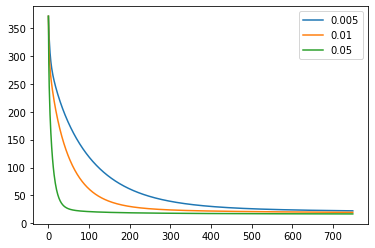

In [11]:
alpha = [0.005, 0.01, 0.05]

cost_sort = []
plt.figure()
for i in alpha:
    _, cost_list = grad(x_train, y_train, i, iters=750)
    cost_sort.append(cost_list[-1])
    plt.plot(range(len(cost_list)), cost_list)

plt.legend(['0.005', '0.01', '0.05'], loc='upper right')
print(cost_sort)

18.471311662204418


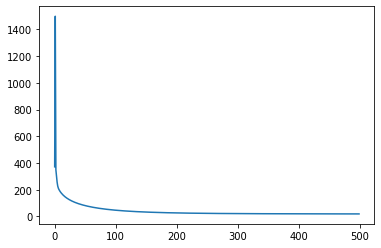

In [12]:
_, ada_cost_list = ada_grad(x_train, y_train, 1, iters=500)

plt.figure()
plt.plot(range(len(ada_cost_list)), ada_cost_list)
print(ada_cost_list[-1])

In [13]:
def get_cost_val(x, y, theta):
    x = np.insert(x, 0, values=np.ones(x.shape[0]), axis=1)

    m = len(x)
    loss = np.dot(x, theta) - y
    cost = np.sum(loss**2) / (2*m)
    return cost

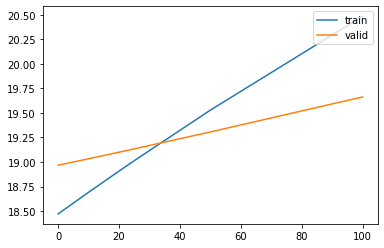

In [14]:
lam = [0, 1, 10, 20, 25, 50, 100]

train_cost_list = []
valid_cost_list = []
for i in lam:
    theta, cost_list = ada_grad(x_train, y_train, alpha=1, lam=i, iters=500)

    train_cost_val = cost_list[-1]
    train_cost_list.append(train_cost_val)
    valid_cost_val = get_cost_val(x_valid, y_valid, theta)
    valid_cost_list.append(valid_cost_val)

plt.figure()
plt.plot(lam, train_cost_list)
plt.plot(lam, valid_cost_list)
plt.legend(['train', 'valid'], loc='upper right')

In [15]:
from numpy.linalg import inv

def close_form(x, y):
    x = np.concatenate((np.ones((x.shape[0],1)), x), axis=1)
    theta = inv(x.T.dot(x)).dot(x.T).dot(y)

    loss = np.dot(x, theta) - y
    cost = np.sum(loss**2) / (len(x) * 2)

    return theta, cost

theta, cost = close_form(x_train, y_train)
cost

16.34059893391479

In [16]:
# 预测测试集

theta, _ = grad(x_train, y_train, 0.05, 0)
np.save('data/weight.npy', theta)
# theta, _ = ada_grad(x_train, y_train, 1, 0)
# theta, _ = close_form(x, y)

testdata = pd.read_csv('data/test.csv', header = None, encoding = 'big5')
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()

test_x = np.empty([240, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)

test_x = normalize(test_x)
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)

test_y = np.dot(test_x, theta)
test_y[test_y < 0] = 0
test_y[:5]

array([[ 3.55090688],
       [13.58679531],
       [18.09509403],
       [ 5.73617479],
       [21.84180326]])

In [17]:
test_list = []
for i in range(len(test_y)):
    item = {'id': 'id_' + str(i), 'value': test_y[i][0]}
    test_list.append(item)
test_df = pd.DataFrame(test_list)
print(test_df)
test_df.to_csv('data/submission.csv', index=False)

id      value
0      id_0   3.550907
1      id_1  13.586795
2      id_2  18.095094
3      id_3   5.736175
4      id_4  21.841803
..      ...        ...
235  id_235  31.662598
236  id_236  52.213483
237  id_237  30.037659
238  id_238  13.338303
239  id_239  12.549223

[240 rows x 2 columns]
